## CNN keras on MINST
> Morgan


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools  # some iteratos like count cycle repeat accumulat etc.

from keras.utils.np_utils import to_categorical # for one-hot encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator # for data augmentation
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


## 1-Data preparation


In [2]:
# Load the data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

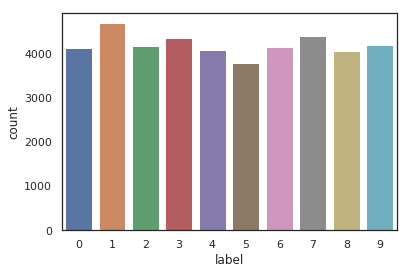

In [3]:
Y_train = train['label']
X_train = train.drop(labels=['label'], axis=1) # Drop the 'label' column

del train # free space

# check the count distribution
g = sns.countplot(Y_train)
Y_train.value_counts()

In [4]:
# check for null and missing values
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
    test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
#X_train = X_train.values.reshape(-1,28,28,1)
#e = plt.imshow(X_train[0][:,:,0])

In [7]:
# Normalization, grayscale normalization to reduce the effect of illumination's differences
X_train = X_train/255.0
test = test/255.0

In [8]:
# Reshape image in 3 dimensions (height = 28px, width = 28px, canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [9]:
# label encoding
# encode labels to one hot vectors
Y_train = to_categorical(Y_train, num_classes=10)

In [10]:
# Split training and valdiation set
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

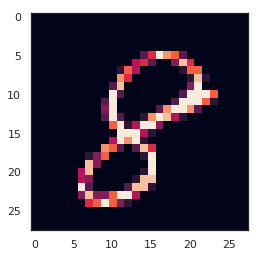

In [11]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

## 2-CNN model

In [12]:
# CNN architechture In > {[Conv2D>relu]x2 > Maxpool2D > Dropout}x2 > Flatten > Dense > Dropout > out
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten()) # Flatten the output and feed into a fully connected layer
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [13]:
# Optimizer 
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) 
# rho is the Gradient moving average decay factor, decay is learning rate decay over each update.

In [14]:
# compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# set a lr annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
epochs = 10
batch_size = 86

In [16]:
# Data augmentation
# avoid overfitting, expand artificially digit dataset. Alter the data with small transformations to reproduce the variations occuring.
# some augmentations techniques: grayscales, horizontal flips, vertical flieps, random crops, colot jitters, 
# translations, rotations, etc.

datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, 
                             featurewise_std_normalization=False,samplewise_std_normalization=False,
                            zca_whitening=False, rotation_range=10,
                            zoom_range=0.1, 
                             width_shift_range=0.1, height_shift_range=0.1,
                             horizontal_flip=False, vertical_flip=False
                            )
datagen.fit(X_train)

# randomly rotate some training images by 10 degrees
# randomly zoom by 10%
# randomly shift images horizontally by 10% of the width
# randomly shift images vertically by 10% of the height

In [17]:
X_train.data.shape
#Y_train.data.shape

(37800, 28, 28, 1)

In [18]:
# fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train,batch_size=batch_size),
                             epochs=epochs,
                             validation_data=(X_val,Y_val),
                             verbose=2, 
                             steps_per_epoch=X_train.shape[0]//batch_size,
                             callbacks=[learning_rate_reduction])


Epoch 1/10
 - 143s - loss: 0.3680 - acc: 0.8833 - val_loss: 0.0778 - val_acc: 0.9769
Epoch 2/10
 - 140s - loss: 0.1426 - acc: 0.9568 - val_loss: 0.0508 - val_acc: 0.9850
Epoch 3/10
 - 141s - loss: 0.1122 - acc: 0.9672 - val_loss: 0.0399 - val_acc: 0.9874
Epoch 4/10
 - 140s - loss: 0.0983 - acc: 0.9705 - val_loss: 0.0389 - val_acc: 0.9886
Epoch 5/10
 - 141s - loss: 0.0936 - acc: 0.9732 - val_loss: 0.0373 - val_acc: 0.9879
Epoch 6/10
 - 140s - loss: 0.0927 - acc: 0.9741 - val_loss: 0.0410 - val_acc: 0.9876
Epoch 7/10
 - 140s - loss: 0.0968 - acc: 0.9743 - val_loss: 0.0568 - val_acc: 0.9860

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/10
 - 140s - loss: 0.0761 - acc: 0.9790 - val_loss: 0.0403 - val_acc: 0.9910
Epoch 9/10
 - 139s - loss: 0.0754 - acc: 0.9789 - val_loss: 0.0472 - val_acc: 0.9890
Epoch 10/10
 - 140s - loss: 0.0780 - acc: 0.9781 - val_loss: 0.0542 - val_acc: 0.9893


## 4-Evaluate the model

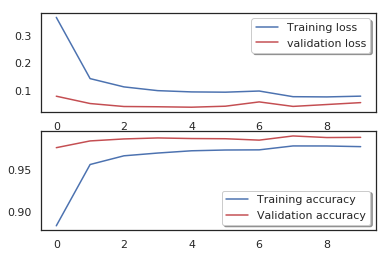

In [19]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='validation loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation accuracy')
legend = ax[1].legend(loc='best', shadow=True)

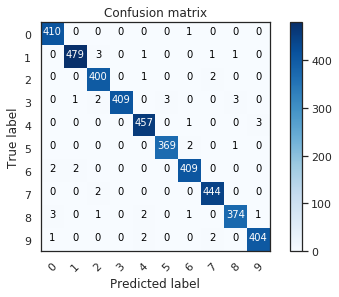

In [20]:
# Confusion matrix 
# it is helpfull to see model drawbacks
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

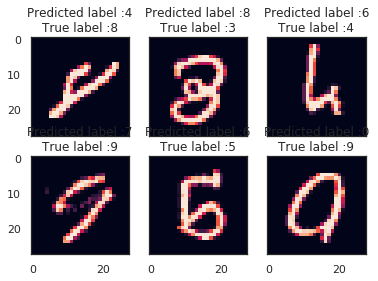

In [21]:
# Display some error results
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [22]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")


In [23]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)